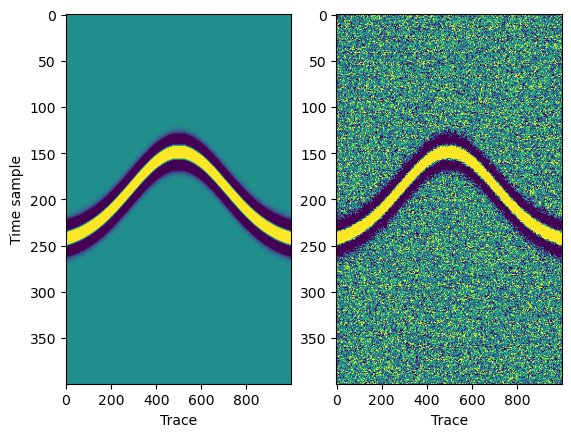

In [1]:
# Prepared On Feb 20, 2025 by Yangkang Chen, UT-Austin
#
# As a reproduced example for two papers
# [1] Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.
# [2] Saad, O. M., & Chen, Y. (2021). A fully unsupervised and highly generalized deep learning approach for random noise suppression. Geophysical Prospecting, 69(4), 709-726.
#
# NOTE: both examples are unsupervised learning approaches. 
# Please use the latest pyseistr package:
# https://github.com/aaspip/pyseistr
#
# Environment: 
# CPU machine
# conda create -n uml python=3.11.7
# conda activate uml
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.14.0 scikit-learn==1.2.2 seaborn==0.13.2 
# 
# GPU machine
# conda create -n uml python=3.10.14
# conda activate uml
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.11.0 scikit-learn==1.2.2 seaborn==0.13.2 
# conda install -c anaconda cudnn==8.2.1
#
#

#generate data
import numpy as np
from pyseistr import gensyn
data,noisy=gensyn(noise=True,var=0.5);[n1,n2]=data.shape;
import matplotlib.pyplot as plt;
plt.subplot(1,2,1);plt.imshow(data,clim=[-0.2,0.2],aspect='auto');plt.xlabel('Trace');plt.ylabel('Time sample');
plt.subplot(1,2,2);plt.imshow(noisy,clim=[-0.2,0.2],aspect='auto');plt.xlabel('Trace');
plt.show();


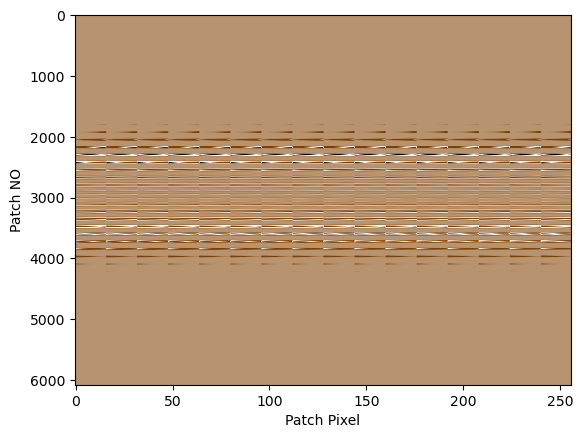

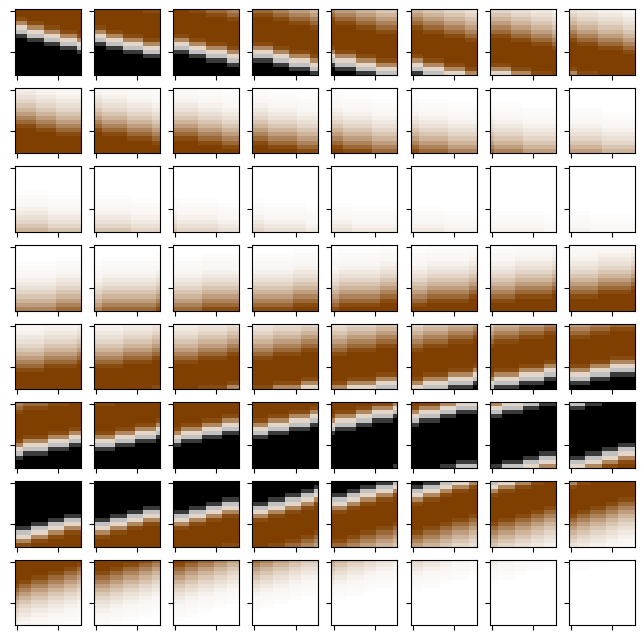

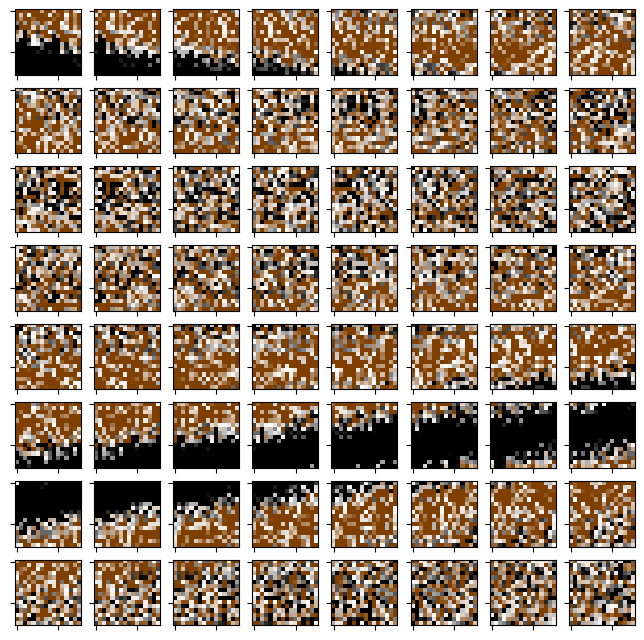

In [2]:
from pyseistr import patch2d,patch2d_inv,snr
X=patch2d(data,l1=16,l2=16,s1=8,s2=8);
Xnoisy=patch2d(noisy,l1=16,l2=16,s1=8,s2=8);

from pyseistr import cseis
plt.imshow(X,aspect='auto',cmap=cseis());plt.ylabel('Patch NO');plt.xlabel('Patch Pixel');plt.show()

# plot clean patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(X[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

# plot noisy patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()


In [3]:
## Deep learning part
# Trying to stabilize the training a bit
seed=2024252699
seed=0
import tensorflow as tf
import numpy as np
import random

random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

from keras import layers
from keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, LeakyReLU,BatchNormalization
# from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# The following architecture was used in 
# Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.

input = layers.Input(shape=(256,))                            #or from tensorflow.keras.layers import Input, Dense
x = layers.Dense(64, activation="relu", name="layer1")(input)  
x = layers.Dense(256, activation="linear", name="layer2")(x)  

# Autoencoder
autoencoder = Model(input,x)
autoencoder.summary()

# Compile
autoencoder.compile(optimizer="adam", loss='mse')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 256)            │        16,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,088 (129.25 KB)

 Trainable params: 33,088 (129.25 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
import datetime
today=datetime.date.today()
weightname='best_model_%s.weights.h5'%str(today)


checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

history=autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=5,callbacks=[checkpoint,lr_reducer],validation_split=0.2)


Epoch 1/5
 1/38 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.1565
Epoch 1: val_loss improved from inf to 0.09069, saving model to best_model_2025-02-20.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1305 - val_loss: 0.0907 - learning_rate: 0.0010
Epoch 2/5
 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0996
Epoch 2: val_loss improved from 0.09069 to 0.08400, saving model to best_model_2025-02-20.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0951 - val_loss: 0.0840 - learning_rate: 0.0010
Epoch 3/5
 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0868
Epoch 3: val_loss improved from 0.08400 to 0.07995, saving model to best_model_2025-02-20.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0852 - val_loss: 0.0799 - learning_rate: 0.0010
Epoch 4/5
 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0815
Epoch 4: val_loss improved from 0.07995 to 0.07717, saving model to best_model_2025-02-20.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.08

In [5]:
Xout = autoencoder.predict(Xnoisy)

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step


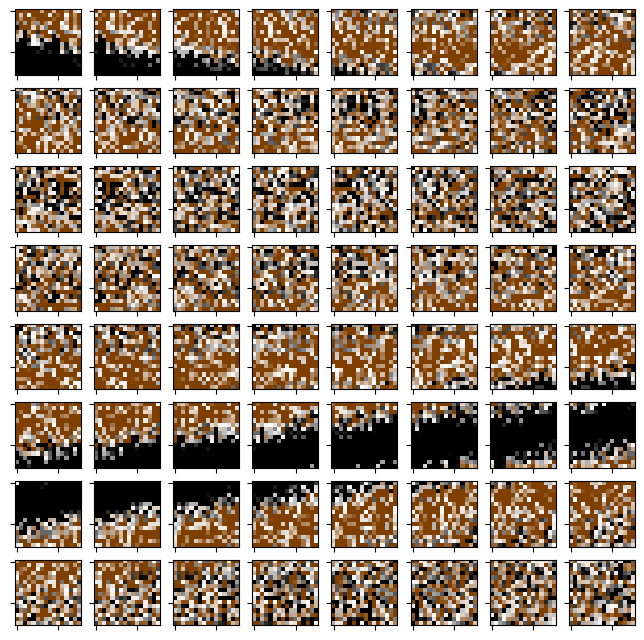

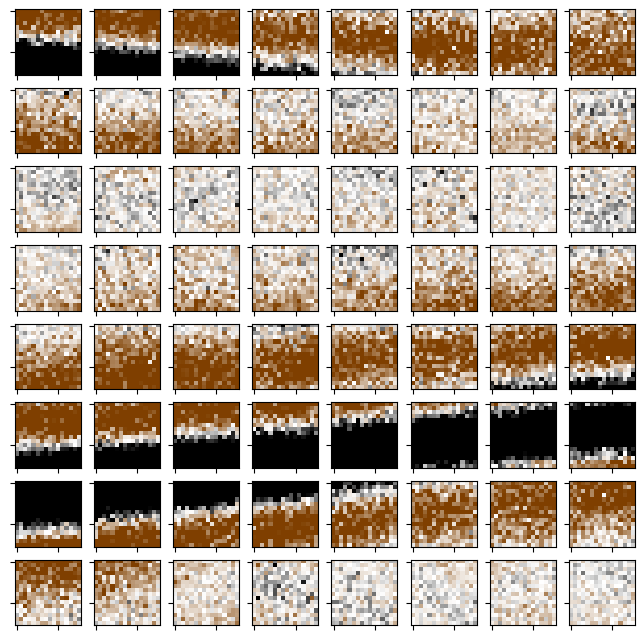

In [6]:
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xout[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()


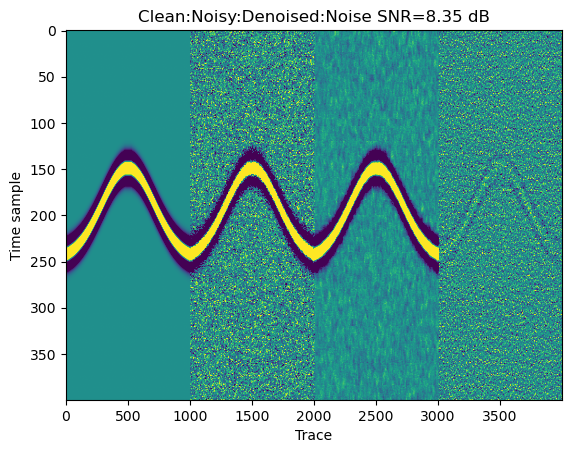

In [7]:
# reconstruct data
denoised=patch2d_inv(Xout,n1,n2,l1=16,l2=16,s1=8,s2=8);

plt.imshow(np.concatenate([data,noisy,denoised,noisy-denoised],axis=1),clim=[-0.2,0.2],aspect='auto');
plt.xlabel('Trace');plt.ylabel('Time sample');plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised)))
plt.show();

In [8]:
# Model.get_state_tree() displays details of the network, and end/intermediate parameters through the training

autoencoder.get_state_tree()

{'trainable_variables': {'layer1': {'kernel': <tf.Variable 'layer1/kernel:0' shape=(256, 64) dtype=float32, numpy=
   array([[-0.00443185,  0.01948351,  0.00364487, ..., -0.00314605,
            0.17830807,  0.04690539],
          [-0.10913368, -0.02360952,  0.02403181, ...,  0.043496  ,
           -0.0098068 , -0.01699561],
          [-0.01350009, -0.08780257,  0.08460151, ...,  0.08236107,
           -0.03749642,  0.0214326 ],
          ...,
          [-0.14928971, -0.16650161, -0.08212082, ...,  0.10948568,
            0.0694114 , -0.02291238],
          [ 0.0644152 , -0.02453163,  0.0459773 , ..., -0.1181052 ,
            0.01522595,  0.02025117],
          [ 0.01816805,  0.02757972,  0.11196728, ..., -0.04981604,
            0.06722921,  0.10124554]], dtype=float32)>,
   'bias': <tf.Variable 'layer1/bias:0' shape=(64,) dtype=float32, numpy=
   array([-0.03327667, -0.01225636, -0.01867452, -0.02072705, -0.02390473,
          -0.01922648, -0.04165882, -0.05102981, -0.01715146, -0.02

In [9]:
# Model.trainable_variables lists weight matrices and bias vectors
# 
# In the case of two layers, "Model.trainable_variables" is a 4-entry list with each entry denoting
# 1. Weight matrix for the first layer
# 2. Bias vector for the first layer
# 3. Weight matrix for the second layer
# 4. Bias vector for the second layer

autoencoder.trainable_variables[0]

<Variable path=layer1/kernel, shape=(256, 64), dtype=float32, value=[[-0.00443185  0.01948351  0.00364487 ... -0.00314605  0.17830807
   0.04690539]
 [-0.10913368 -0.02360952  0.02403181 ...  0.043496   -0.0098068
  -0.01699561]
 [-0.01350009 -0.08780257  0.08460151 ...  0.08236107 -0.03749642
   0.0214326 ]
 ...
 [-0.14928971 -0.16650161 -0.08212082 ...  0.10948568  0.0694114
  -0.02291238]
 [ 0.0644152  -0.02453163  0.0459773  ... -0.1181052   0.01522595
   0.02025117]
 [ 0.01816805  0.02757972  0.11196728 ... -0.04981604  0.06722921
   0.10124554]]>

In [10]:
autoencoder.trainable_variables[1]

<Variable path=layer1/bias, shape=(64,), dtype=float32, value=[-0.03327667 -0.01225636 -0.01867452 -0.02072705 -0.02390473 -0.01922648
 -0.04165882 -0.05102981 -0.01715146 -0.02385844 -0.04081139 -0.02876056
 -0.01330497 -0.02670768 -0.01431898 -0.03684709 -0.01883547 -0.05088841
 -0.05045686 -0.03040338 -0.01821431 -0.02179917 -0.03888879 -0.03492703
 -0.02141355 -0.03424602 -0.0648228  -0.03154796 -0.03337393 -0.03614061
 -0.03393309 -0.03250273 -0.03064932 -0.0440015  -0.02359935 -0.00441958
 -0.0449216  -0.05542008 -0.0177575  -0.02371254 -0.02664555 -0.02728559
 -0.03244541 -0.00407489 -0.00573307 -0.05279924 -0.03556316 -0.05551887
 -0.03578968 -0.03131638 -0.02612022 -0.0320106  -0.04230111 -0.0164837
 -0.01795243 -0.02455802 -0.02408151 -0.04402975 -0.04853235 -0.03498162
 -0.0288811  -0.03606616 -0.02732089 -0.03342542]>

In [11]:
autoencoder.trainable_variables[2]

<Variable path=layer2/kernel, shape=(64, 256), dtype=float32, value=[[-0.00772287 -0.0878175  -0.0149656  ... -0.15483224  0.05449235
   0.00125737]
 [ 0.03840944 -0.04468409 -0.11177859 ... -0.19675188 -0.00953202
  -0.04400826]
 [-0.03092664  0.03801269  0.12446224 ... -0.06097978  0.04254716
   0.10333633]
 ...
 [-0.09322808  0.07406016  0.13632995 ...  0.06812507 -0.13199073
  -0.06983994]
 [ 0.1515442   0.0821295  -0.02085177 ...  0.07666811  0.01602652
   0.05110936]
 [ 0.05805511  0.01916868  0.01522346 ... -0.08173318  0.03877624
   0.13827796]]>

In [12]:
autoencoder.trainable_variables[3]

<Variable path=layer2/bias, shape=(256,), dtype=float32, value=[-2.17438526e-02 -7.65825156e-03 -9.43741482e-03 -3.12992260e-02
 -2.84460131e-02 -2.82257708e-04 -1.29172076e-02 -1.39657240e-02
  1.34175655e-03 -9.59536619e-03 -5.53146144e-03 -4.24052449e-03
  5.86284604e-03 -3.06805950e-02 -7.44129205e-03 -1.23765813e-02
 -1.55960508e-02 -2.41000708e-02 -1.67842582e-02 -2.27702680e-04
 -1.93520193e-03 -1.94590576e-02 -1.74882896e-02 -1.40187722e-02
  8.39485601e-03  6.78439718e-03  4.05244203e-03  7.32839946e-03
 -4.24139807e-03 -2.76965313e-02  2.78522377e-03 -2.17641797e-02
 -4.37745526e-02 -2.60542389e-02 -3.09976377e-02 -1.50945445e-03
 -9.08376276e-03 -3.23329680e-02  5.92424860e-03  3.43920663e-02
  6.21006452e-03 -6.28742483e-03 -3.21539193e-02  3.31038982e-02
 -2.42369100e-02  3.29859252e-03  4.05740645e-03 -1.52856074e-02
 -1.16421999e-02 -2.65078545e-02 -3.10706962e-02 -1.85269769e-02
 -1.26465186e-02 -1.33668240e-02 -6.77839806e-03 -3.28030847e-02
 -3.09084337e-02 -1.1351063

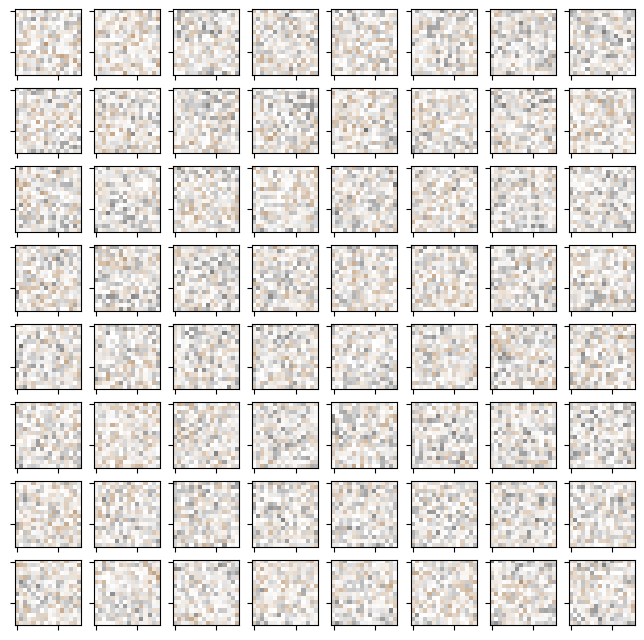

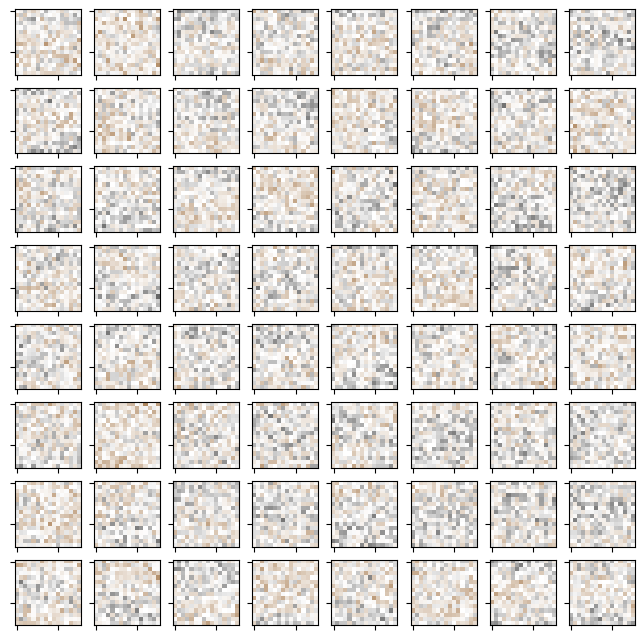

In [13]:
## We can plot the weight matrix to explain/interpret the autoencoder architecture
#
# Key math here:
# y_middle=x*W1+b1;  
# 
# NOTE: 
# x is the input training data; y_middle is the intermediate output after the first layer
# The size of each variable is 
# x: nsamples*256; W1: 256*64; b1: 64*1
# each row in x (e.g., Xnoisy after pyseistr.patch2d) denotes a 2D patch (reshaped to 1D vector)
# each column in W1 is a feature vector (2D reshaped into 1D format)
# b1 denotes the noise level (unpredictable parts in the data) 

W1=autoencoder.trainable_variables[0].numpy()
b1=autoencoder.trainable_variables[1].numpy()


plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(W1[:,ii].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()


## layer 2
#
# y=y_middle*W2+b2;  
# 
# NOTE: 
# y is the predicted output; y_middle is the intermediate output after the first layer
# The size of each variable is 
# y: nsamples*256; W2: 64*256; b2: 256*1
# each row in y (e.g., Xout for pyseistr.patch2d_inv) denotes a 2D patch (reshaped to 1D vector)
# each row in W2 is a feature vector (2D reshaped into 1D format)
# b2 denotes the noise level (unpredictable parts in the data) 

W2=autoencoder.trainable_variables[2].numpy()
b2=autoencoder.trainable_variables[3].numpy()

plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(W2[ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()



Epoch 1/100
 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0754
Epoch 1: val_loss improved from 0.07496 to 0.07308, saving model to best_model_2025-02-20.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0750 - val_loss: 0.0731 - learning_rate: 0.0010
Epoch 2/100
 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0732
Epoch 2: val_loss improved from 0.07308 to 0.07150, saving model to best_model_2025-02-20.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0730 - val_loss: 0.0715 - learning_rate: 0.0010
Epoch 3/100
 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0714
Epoch 3: val_loss improved from 0.07150 to 0.07018, saving model to best_model_2025-02-20.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0713 - val_loss: 0.0702 - learning_rate: 0.0010
Epoch 4/100
 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0699
Epoch 4: val_loss improved from 0.07018 to 0.06912, saving model to best_model_2025-02-20.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

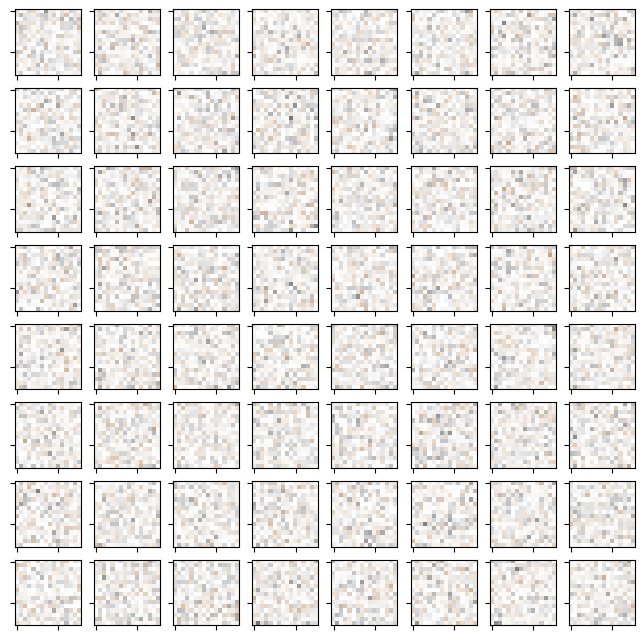

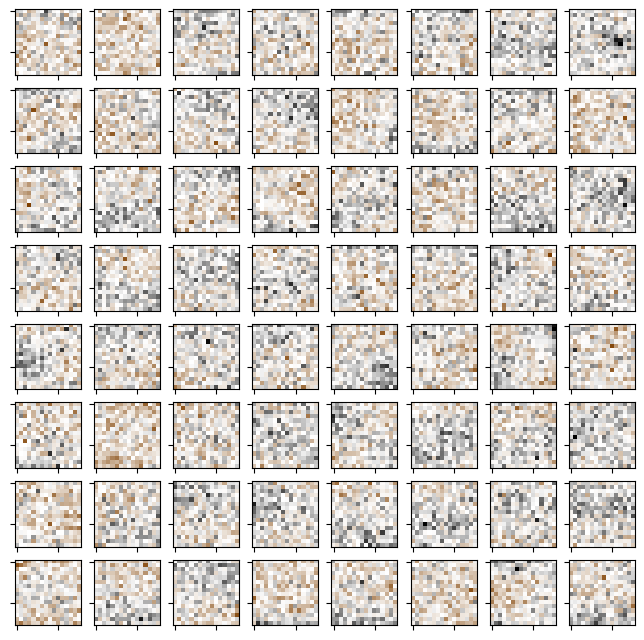

In [14]:
# The difference is not clear
# Let's try more epochs

# input = layers.Input(shape=(256,))                            
# x = layers.Dense(64, activation="relu", name="layer1")(input)  
# x = layers.Dense(256, activation="linear", name="layer2")(x)  
# autoencoder = Model(input,x)
# autoencoder.compile(optimizer="adam", loss='mse')
history2=autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=100,callbacks=[checkpoint,lr_reducer],validation_split=0.2)

W1=autoencoder.trainable_variables[0].numpy()
b1=autoencoder.trainable_variables[1].numpy()
W2=autoencoder.trainable_variables[2].numpy()
b2=autoencoder.trainable_variables[3].numpy()


plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(W1[:,ii].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(W2[ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()


# Now the differences are clear
# Through iterations of training, the decoder features gradually capture the patterns in the data

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step


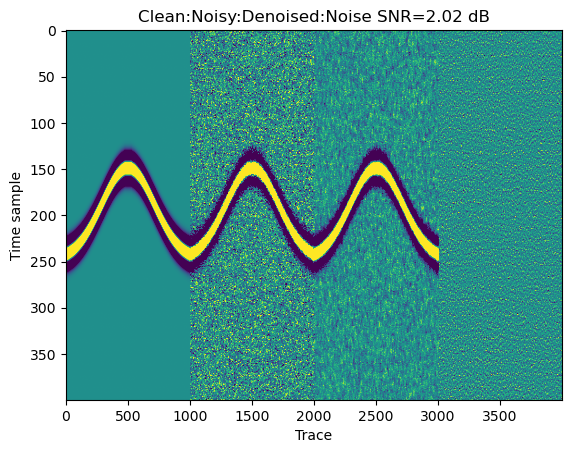

In [15]:
# How about the new denoising data?

Xout = autoencoder.predict(Xnoisy)
denoised2=patch2d_inv(Xout,n1,n2,l1=16,l2=16,s1=8,s2=8);

plt.imshow(np.concatenate([data,noisy,denoised2,noisy-denoised2],axis=1),clim=[-0.2,0.2],aspect='auto');
plt.xlabel('Trace');plt.ylabel('Time sample');plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised2)))
plt.show();

# Obviously, more epochs help recover more noise


400 1000 1 5 5 1 20 0.0 1


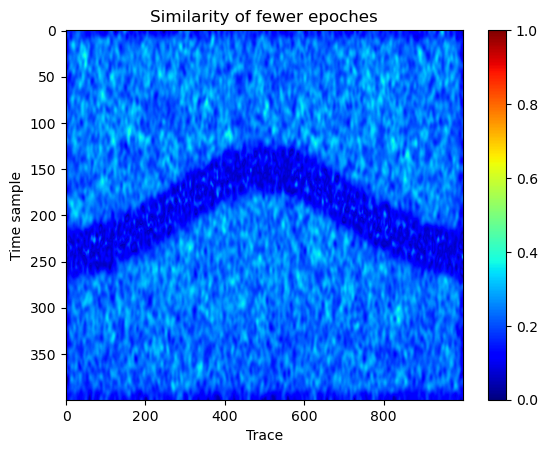

400 1000 1 5 5 1 20 0.0 1


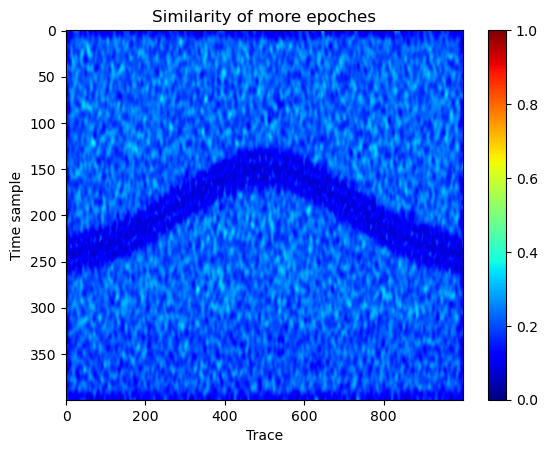

In [16]:
# Measuring similarity (Chen and Fomel, 2015) 
# pip install pyortho
# 
# Here is an example
from pyortho import localsimic
signal1=denoised;
noise1=noisy-denoised;
simi1=localsimic(signal1,noise1,[5,5,1],niter=20);

plt.imshow(simi1,cmap='jet',clim=[0,1],aspect='auto');
plt.colorbar()
plt.xlabel('Trace');plt.ylabel('Time sample');
plt.title('Similarity of fewer epoches')
plt.show();


signal2=denoised2;
noise2=noisy-denoised2;
simi2=localsimic(signal2,noise2,[5,5,1],niter=20);

plt.imshow(simi2,cmap='jet',clim=[0,1],aspect='auto');
plt.colorbar()
plt.xlabel('Trace');plt.ylabel('Time sample');
plt.title('Similarity of more epoches')
plt.show();



400 1000 1 5 5 1 20 0.0 1


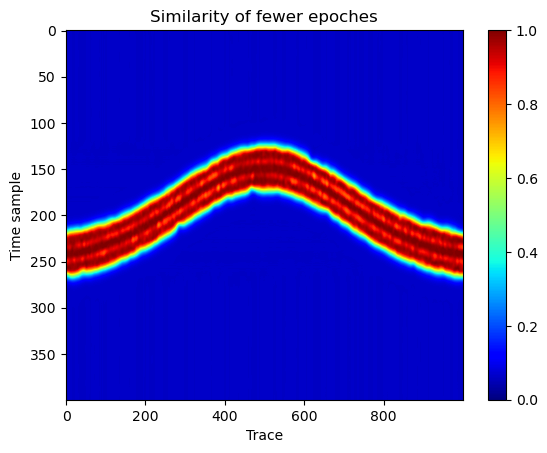

400 1000 1 5 5 1 20 0.0 1


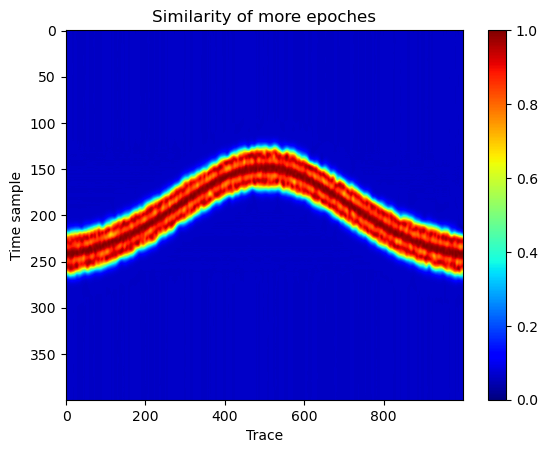

In [17]:
plt.imshow(localsimic(data,denoised,[5,5,1],niter=20),cmap='jet',clim=[0,1],aspect='auto');
plt.colorbar()
plt.xlabel('Trace');plt.ylabel('Time sample');
plt.title('Similarity of fewer epoches')
plt.show();

plt.imshow(localsimic(data,denoised2,[5,5,1],niter=20),cmap='jet',clim=[0,1],aspect='auto');
plt.colorbar()
plt.xlabel('Trace');plt.ylabel('Time sample');
plt.title('Similarity of more epoches')
plt.show();


In [18]:
## Why, in this case with quite strong noise, fewer epochs cause stronger noise/signal similarity
# Just because, more iterations are no more than adding slightly more noise back (learning slightly more noise, slightly more overfitting)
# so that less noise is in the removed noise section and the recovered signals are contaminated by slightly more noise
# causing the lower similarity between the two-part noise and lower fidelity of the signal
#
# See the following loss plots, which show adding more epochs really does not help a lot. 
#  
# REMEMBER: it is just because we use a very simple neural network architecture (two layers), so the learning ability is very weak.
# If we use a complicated architecture, the story is completely different.
# AS a homework for exploring the more complicated architecture?
#
# NOTE: the results may be slightly different due to the randomization nature of deep learning
# 
# Prepared by Yangkang Chen, Feb 20, 2025


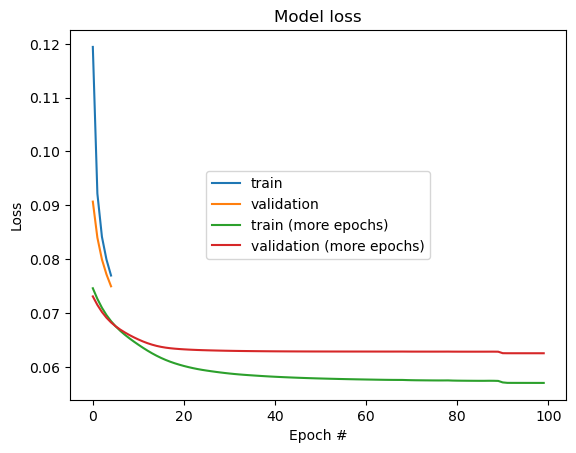

In [19]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(['train', 'validation', 'train (more epochs)', 'validation (more epochs)'], loc='center')
plt.show()




DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/SCons-4.8.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
flow= 0 fhigh= 124 dt= 0.004 N= 12 K= 4 verb= 0
n1win= 50 n2win= 50 r1= 0.5 r2= 0.5 r3= 0.5
(400, 1000, 1)
flow= 0 fhigh= 124 dt= 0.004 N= 12 K= 4 verb= 0


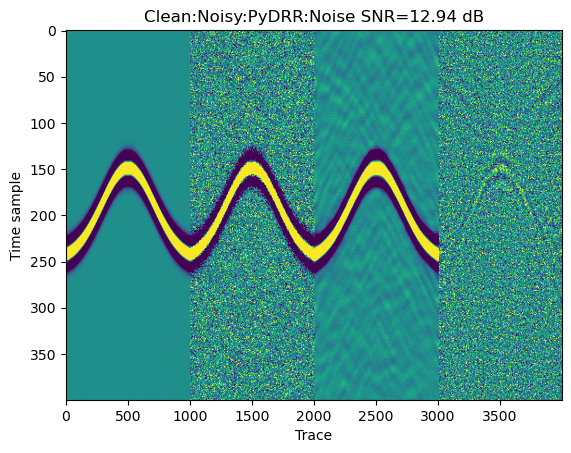

In [20]:
# Just have a general idea of what a SOTA denoising approach can do for this data (further tuning can hopefully improve)
# !pip install pydrr
# import pydrr
# denoised3=pydrr.drr3d_win(noisy, flow=0, fhigh=124, dt=0.004, N=12, K=4, verb=0, n1win=50, n2win=50, n3win=None, r1=0.5, r2=0.5, r3=0.5)

# plt.imshow(np.concatenate([data,noisy,denoised3,noisy-denoised3],axis=1),clim=[-0.2,0.2],aspect='auto');
# plt.xlabel('Trace');plt.ylabel('Time sample');plt.title('Clean:Noisy:PyDRR:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised3)))
# plt.show();


In [21]:
# See how previous run is different from the new one
#
print('Denoised (100 epochs) data has a variance of', denoised2.var(),'as compared with 0.04014934471927431 of last run by YC in Feb 2025')


Denoised (100 epochs) data has a variance of 0.04014934471927431 as compared with 0.04014934471927431 of last run by YC in Feb 2025
